CS119 Big Data

Spring 2024

# Part 1 - TrafficRank

## Question 0: Create Data Visualization

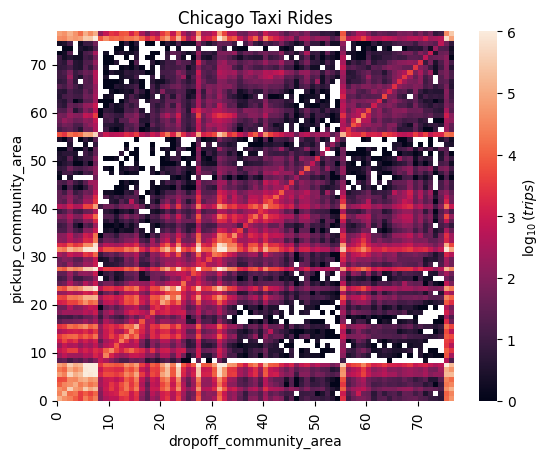

In [239]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('chicago-taxi-rides.csv')
df['log_trips'] = np.log10(df['trips'])
df.dropna(inplace=True)
ax = sns.heatmap(df.pivot(index='pickup_community_area', columns='dropoff_community_area', values='log_trips'), cbar_kws={'label':r'$\log_{10}(trips)$'}, vmax=6)
plt.title('Chicago Taxi Rides')
plt.xticks(np.arange(0, 80, 10))
plt.yticks(np.arange(0, 80, 10))
ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()])
ax.set_xticklabels(['{:,.0f}'.format(x) for x in ax.get_xticks()])
plt.gca().invert_yaxis()
plt.show()

## Question 1: Read the data as a matrix

In [240]:
import scipy.sparse


data = pd.read_csv('chicago-taxi-rides.csv').dropna().to_dict('list')
num_regions = int(max(data['pickup_community_area']))
trips = np.array(data['trips'], dtype=int)
total_trips = sum(data['trips'])
# in Matrix formulation of PageRank, columns link out to rows, so we use pickup locations as "linking to" dropoff areas
# I.e. areas are more important if the people that take taxis to them do it from important areas
row = np.array(data['dropoff_community_area'], dtype=int)
col = np.array(data['pickup_community_area'], dtype=int)

coo = scipy.sparse.coo_matrix((trips, (row, col)), shape=(num_regions+1, num_regions+1), dtype=float)


## Question 2: Calculate the rankings of the areas after 0-6 iterations

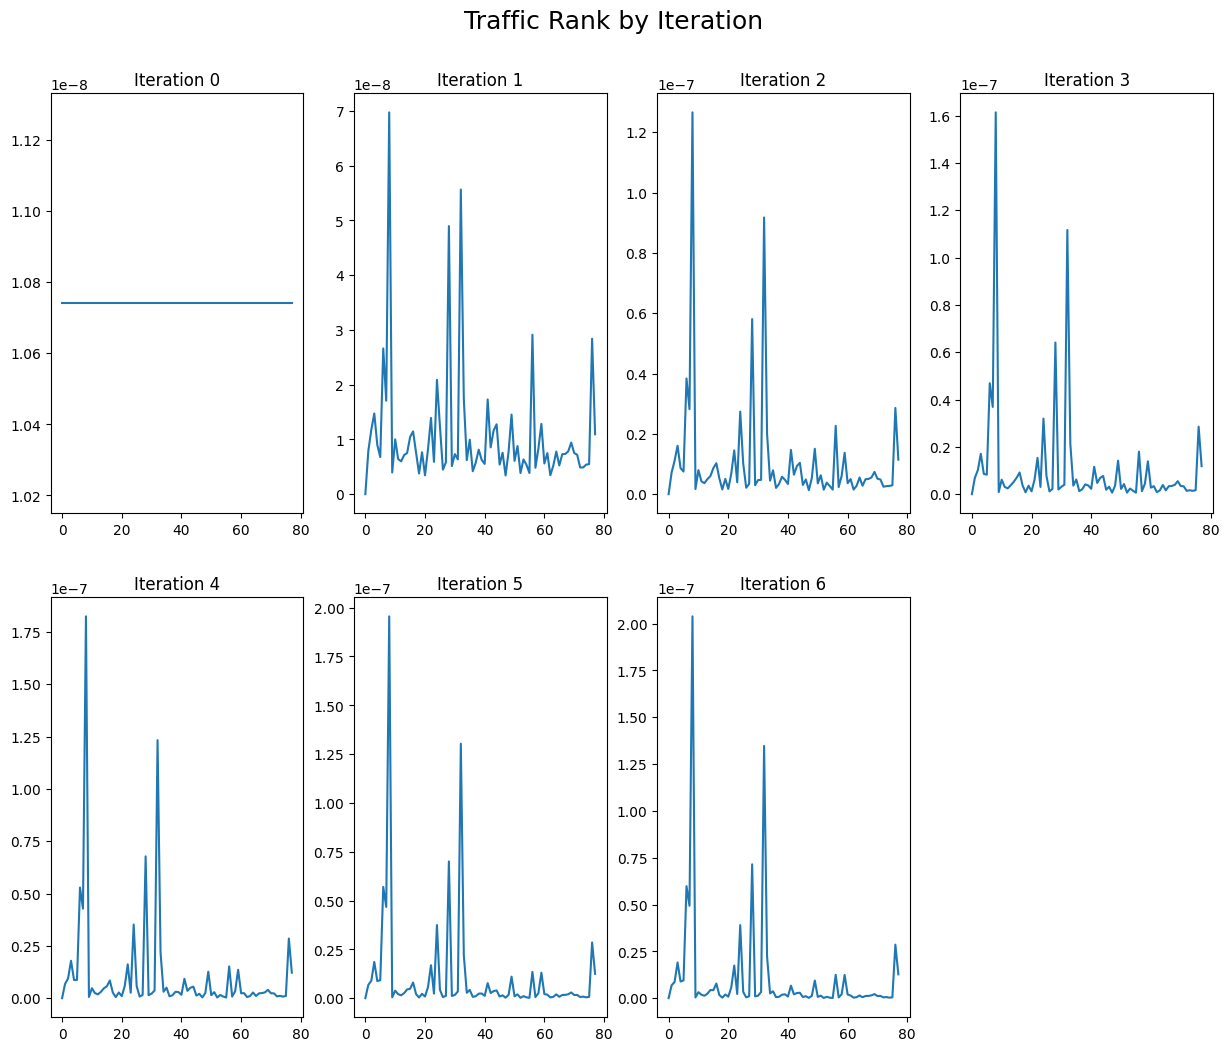

Most important Areas in Descending order:

      Traffic Importance  Traffic Importance Rank
Area                                             
8           2.038490e-07                        1
32          1.346924e-07                        2
28          7.146746e-08                        3
6           5.982486e-08                        4
7           4.934417e-08                        5
...                  ...                      ...
54          2.711516e-10                       73
74          2.666062e-10                       74
47          1.814548e-10                       75
52          1.287794e-10                       76
55          1.047391e-10                       77

[77 rows x 2 columns]


In [241]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

M = coo.tocsr()
# normalize so that all columns sum to 1 - this is now the stochastic adjacency matrix
M = normalize(M, norm='l1', axis=0)
r = np.ones(num_regions+1) / total_trips
plt.figure(figsize=(15,12))
plt.suptitle("Traffic Rank by Iteration", fontsize=18, y=0.95)
for i in range(7):
    if i != 0:
        r = M*r
    ax = plt.subplot(2,4, i+1)
    ax.plot(r)
    ax.set_title(f'Iteration {i}')
plt.show()
# r = M*r

results_df = pd.DataFrame(r, columns=['Traffic Importance'])
results_df.index.name = "Area"
# Area 0 does not exist, so drop
results_df.drop(0, axis=0, inplace=True)
results_df.sort_values(by='Traffic Importance', ascending=False, inplace=True)
results_df['Traffic Importance Rank'] = list(range(1, results_df.shape[0] + 1))
print('Most important Areas in Descending order:\n')
print(results_df)
# print(r.argsort()[::-1])

## Question 3: Correlation with hardship index

Text(0.5, 1.0, 'Inverse Harship Index vs TrafficRank')

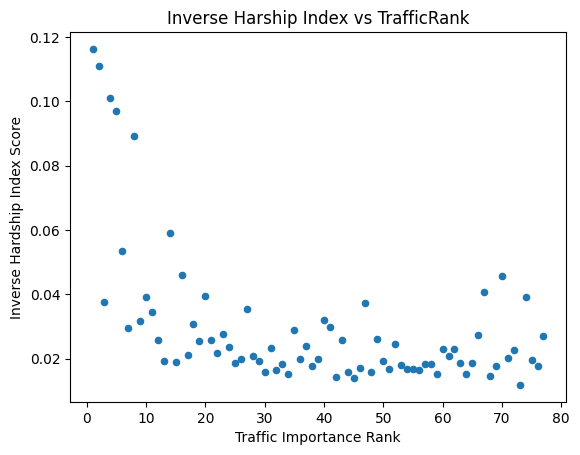

In [242]:
hardship_df = pd.read_csv('hardship_index.csv', index_col="Community Area Number")
full_df = hardship_df.join(results_df)
full_df['Inverse Hardship Index Score'] = 1/full_df['Hardship Index Score']
# print(full_df)
full_df.plot.scatter(x='Traffic Importance Rank', y='Inverse Hardship Index Score')
plt.title('Inverse Harship Index vs TrafficRank')


My results show some relationship with the given harship index, especially on the high end of the TrafficRank index. There are 5 areas that have by far the least hardship in the top, that also correspond with some of the highest ranked areas based on traffic. However, after those 5 points, there is very little correlation at all. This result makes intuitive sense - if those 5 areas are commercial or business districts, where people take taxis to all the time for business or pleasure, they would naturally be naturally be the most visited by taxi and therefore be wealthy because of the business they bring in. The remaining areas may be more residential - people typically only take taxis to them when they are returning home, and there is a larger variance in those area's wealth.

I'm not surprised that there is little correlation between traffic rank and hardship for what may be residential neighborhoods - there are a lot more factors that go into hardship than just how often they are visited by taxis.

# Part 2 - Text Processing

## Question 1: IDF Calculation

IDF applies only to a collection or corpus of text because it was designed for use in detemining how important a word is to the meaning of a document, relative to other documents. For example, when used by seach engines, this can be used to find the most relevant document to a user's query. By finding words that only appear in certain documents, it can score and rank each document's relevance to the query. This would not apply if there was only one document, since the document frequency for each word would simply be 1, and we wouldn't be able to tell which words appear in documents all the time vs. just this document.

## Question 2: Scikit-Learn's IDF Implementation

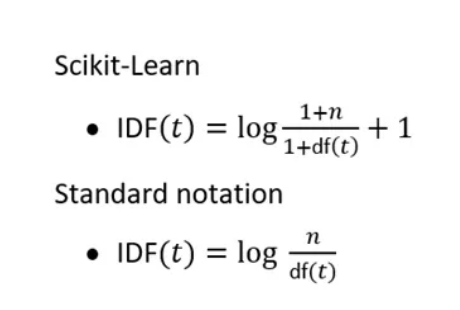

There are 3 extra '+1's' added to scikit-learns idf implementation, all of which have there own purpose and justification. 

The +1 that is farthest to the right, outside the fraction, adds 1 to all words, thus boosting all idfs by a small amount. Since the standard notation idf gives an idf of 0 for all words that appear in every document, this has the effect of allowing all idfs to be above 0, so that even very common words will not be entirely ignored. One reason this may be desireable is if the user has already removed stop words, and may still have some interest in remaining words that appear in all documents.

The other +1's each in the numerator and denominator are used when the parameter "smooth_idf" is passed in as True, which is the default, acting as though an additional document exists that contains every word exactly once. This has two effects - first, it smooths the idf weights slightly, so that the most extreme values (i.e. words that appear only once) are not as extreme. Second, it prevents zero divisions in the case where the user uses a custom vocabulary that contains words that do not appear in any of the documents.

## Question 3: Procedure for Calculating 

In [243]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import tarfile
import shutil
import requests
import re
import pandas as pd

def remove_stopwords(words) -> list[str]:
    '''
    Removes stopwords from a corpus of words and return as a list
    '''
    stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
    stopwords = set(stopwords_list.decode().splitlines())
    stopwords = list(stopwords)
    # Headings of text file
    stopwords += ['title', 'date']
    # Removing generic presidential words that do not give much info about the speaker
    stopwords += ['america', 'american', 'country', 'government', 'nation', 'nations', 'people', 'united', 'state', 'states', 'year', 'years', 'national']
    list_ = re.sub(r"[^a-zA-Z0-9]", " ", words.lower()).split()
    return [itm for itm in list_ if itm not in stopwords]

def get_content_no_stopwords(directory: str) -> None:
    '''
    Looks through all files in a directory, and stores each files content as a single string, returning a list of these strings for each file in the directory 
    '''
    content = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as f:
            words = f.read()
            # for line in lines:
            words_cleaned = remove_stopwords(words)
            file_content = ' '.join(words_cleaned)
        content.append(file_content)

    return content

def get_speech_words(name:str) -> None:
    '''
    Gets the 15 most important words in a given president's speeches according to the td-idf method and prints the words in descending order of importance. Considers importance to be the maximum tf-idf score a word gets across any document.
    '''
    print('President ' + name.title() )
    tar = tarfile.open('prez_speeches/' + name.lower() + '.tar.gz')
    tar.extractall('prez_speeches')
    tar.close()
    # Temporary uncompressed directory name
    uncompressed_dir = 'prez_speeches/' + name.lower()
    speech_files = [f for f in os.listdir(uncompressed_dir) if os.path.isfile(os.path.join(uncompressed_dir, f))]

    content = get_content_no_stopwords(uncompressed_dir)

    vectorizer = TfidfVectorizer(input='content', use_idf=True)
    tfidf_matrix = vectorizer.fit_transform(content)
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    
    # Take the max of each column (converting to pandas series) and sort
    tfidf_series = tfidf_df.max().sort_values(ascending=False).head(15)
    print(tfidf_series.index.to_list())
    # Remove temp directory
    shutil.rmtree(uncompressed_dir)

# Example usage:
get_speech_words('Adams')

President Adams
['counties', 'death', 'day', 'minister', 'washington', 'person', 'treason', 'persons', 'president', 'insurrection', 'sir', 'france', 'mind', 'gentlemen', 'commissioners']


## Question 3: Calculate Results for all presidents

The code below displays the results for all presidents provided. Many of the words are clearly related to the given president - for example Lincoln's speeches include words like 'slavery', 'war', and 'union', whereas Clinton's speeches include words like 'somalia', 'nafta', and 'rwanda', words that are clearly associated with each president's term. It is somewhat unintuitive that this would be the result here based on the calculation methodology - what is happening here is the tf-idf algorithm is being used to calculate which words are most important in distinguishing individual speeches of a given president from other individual speeches given by that same president. Then, the maximum influence each word has on any particular speech is then used as a proxy for that words importance. For example, if president Clinton gave one speech focused on Somalia, and rarely mentioned it in other speeches, that would result in a very high word importance for the word Somalia, since the word Somalia is useful for distinguishing that speech from the others.

As a result, the words that are are given the highest importance are the words that are most likely to be speech topics - something that only one speech is about, and not others. This mostly excludes more generic terms from the most importance list, since those terms are likely to come up in most speeches, and therefore not have much distinguishing power. The result is a list of words that largely corresponds to speech topics, and therefore important words associated with each president's term. Additionally, I added preprocessing to remove known stop words and generic words that I did not want appearing on the list, such as "american", "united", and "states," to further remove unwanted words.

In [244]:
# Print results for all presidents
for filename in os.listdir('prez_speeches'):
    prez_name = filename.split('.')[0]
    get_speech_words(prez_name)
    print()

President Wilson
['business', 'peace', 'registration', 'german', 'law', 'alien', 'huerta', 'tests', 'tariff', 'imperial', 'enemy', '000', 'vessels', 'declaration', 'questions']

President Cleveland
['chinese', 'statue', 'gold', 'pension', 'officeholders', 'silver', 'political', 'monroe', 'provisional', 'treaty', 'write', 'treasury', 'bonds', 'war', 'obstructions']

President Tyler
['rhode', 'assent', 'mexico', 'island', 'texas', 'china', '000', 'corporation', 'islands', 'florida', 'public', 'lake', 'office', 'crew', 'maps']

President Taft
['tax', 'tariff', 'land', 'schedule', 'lands', 'canada', 'income', 'public', 'agreement', 'commerce', 'interstate', 'water', 'revision', 'session', 'soils']

President Madison
['bank', 'church', 'territory', '000', 'british', 'constitution', 'specie', 'power', 'enemy', 'war', 'president', 'possession', 'notes', 'religious', 'day']

President Buchanan
['committee', 'virginia', 'kansas', 'city', 'lands', 'negroes', 'constitution', 'troops', 'captured',